# DCGAN

We implement the following architecture shown in the paper ***DCGANs for image super-resolution, denoising and debluring***,by Yan and Weng.


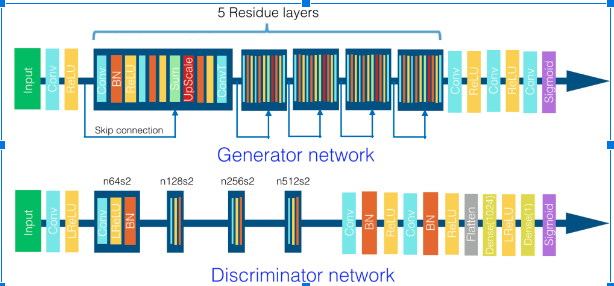

Note that we did not include the upscaling layers, as they were used in the article to perform super resolution. Note that the generator takes a [7, 128] image as input and outputs an image of the same size. The final ‘sigmoid’ layer at the generator was replace by a ‘Tanh’ layer as our range of values is [-1,1].


The loss function we minimize is composed of the content loss between a dereverberated image and its clean target, and by the regular adversarial loss:


$l_G=0.9*l_{content}+0.1*l_{G,adv}$

where:

$l_{content}=​‖I_{generated}-I_{original}‖_1=​‖I_{dereverberated}-I_{clean target}‖_1$

 between a reverberated image and its clean target, 

and by the regular adversarial loss:

$l_{G,adv}=\sum_{n=1}^{N}-log D(G(I^{reverberated}))$



The discriminator loss function is the adverserial loss:

$l_{D,adv}=\sum_{n=1}^{N}log D(G(I^{reverberated})) + log(1-D(I^{clean_target})))$

In [1]:
project_dir = '../'

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

### Constants

In [3]:
root_dir = project_dir +  'Fixed Data/'
# Number of training epochs
num_epochs = 20
# Learning rate for optimizers
lr = 0.0002
# Number of workers for dataloader
workers = 4
# Batch size during training
batch_size = 256
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Data

In [4]:
class CustomImageDataset(Dataset):
    """"""
    def __init__(self, root_dir, is_test=False, normalize=False, split_parts=False):
        """
        :param root_dir:
        :param is_test:
        :param normalize: If not False, should be a nd.array of the form
         np.array([mean_left,std_left,mean_right,std_right])
        """
        dirs = os.listdir(root_dir)
        dirs = [dir for dir in dirs if dir.startswith('Test') == is_test]
        self.revs = None
        self.targets = None

        for dir in dirs:
            rev_target_dirs = os.listdir(os.path.join(root_dir, dir))
            rev_dir = [d for d in rev_target_dirs if d.startswith('beta = 0.160')][0]
            target_dir = [d for d in rev_target_dirs if d.startswith('Target')][0]
            rev = os.path.join(root_dir, dir, rev_dir, 'data_phase.npy' if is_test else 'data_phase.npy')
            a = np.load(rev)

            if self.revs is None:
                self.height = a.shape[1]
                self.width = a.shape[2]
                if split_parts:
                    self.width = self.width // 2

            if normalize is not False:
                a[:,:,:self.width//2] = (a[:,:,:self.width//2] - normalize[0])/normalize[1]
                a[:,:,self.width//2:] = (a[:,:,self.width//2:] - normalize[2])/normalize[3]

            if split_parts:
                a = np.concatenate([a[:, :, :125], a[:, :, 125:]], axis=0)

            if self.revs is None:
                self.revs = np.copy(a)
            else:
                self.revs = np.vstack((self.revs, a))
            target = os.path.join(root_dir, dir, target_dir, 'data_phase.npy')
            b = np.load(target)

            if split_parts:
                b = np.concatenate([b[:, :, :125], b[:, :, 125:]], axis=0)

            if self.targets is None:
                self.targets = np.copy(b)
            else:
                self.targets = np.vstack((self.targets, b))

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        reverberated_image = self.revs[idx, :, :] / np.pi
        target_image = self.targets[idx, :, :] / np.pi
        pad = 128 - self.width
        reverberated_image = np.pad(reverberated_image, ((0, 0), (pad, 0)), 'constant', constant_values=0)
        target_image = np.pad(target_image, ((0, 0), (pad, 0)), 'constant', constant_values=0)

        reverberated_image = reverberated_image.reshape(1, 7, -1)
        target_image = target_image.reshape(1, 7, -1)
        return torch.from_numpy(reverberated_image), torch.from_numpy(target_image)


## DCGAN Model

### ResBlock Module

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device, weight_std=1e-3):
        # in_channel
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Projection in series if needed prior to shortcut
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1, stride=1, padding='same')
        torch.nn.init.trunc_normal_(self.conv1x1.weight, 0, 1)
        self.projection_block = nn.Sequential(
            self.conv1x1,
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ).to(device)


        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, [7,3], stride=1, padding='valid'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ).to(device)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, [7,3], stride=1, padding='valid'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ).to(device)

    def forward(self, x):
        # TODO: forward
        if self.out_channels != x.shape[1]:
            residual = self.projection_block(x)
        else:
            residual = x

        x = self.pad(x)
        x = self.conv_block1(x)
        x = self.pad(x)
        x = self.conv_block2(x)
        x = x + residual
        return x

    def pad(self, x):
        x = F.pad(x, (0, 0, 3, 3), mode='circular')
        x = F.pad(x, (1, 1, 0, 0), mode='constant')
        return x



### Generator Module

In [6]:
class Generator(nn.Module):
    def __init__(self, device, n_res_blocks=5, input_shape=[1, 7, 126]):
        super(Generator, self).__init__()
        self.in_shape = input_shape  # [n_channels, height, width]
        self.n_units = 64
        self.res_units = [64, 64, 64, 64, 64]
        self.device = device


        self.first_blocks = nn.Sequential(
            nn.Conv2d(in_channels=self.in_shape[0], out_channels=self.n_units, kernel_size=[7,3], stride=1, padding='valid'),
            nn.ReLU()
        ).to(device)

        self.res_blocks = nn.Sequential(
            ResBlock(in_channels=self.n_units, out_channels=self.res_units[0], device=device),
            *[ResBlock(in_channels=self.res_units[0], out_channels=self.res_units[i], device=device) for i in
              range(1, n_res_blocks)]
        ).to(device)

        self.final_blocks = nn.Sequential(
            nn.Conv2d(in_channels=self.res_units[-1], out_channels=self.n_units, kernel_size=[7,3], stride=1,
                      padding='valid'),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.n_units, out_channels=self.n_units, kernel_size=1, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.n_units, out_channels=input_shape[0], kernel_size=1, stride=1, padding='same'),
            # nn.Sigmoid()
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        x = self.pad(x)
        x = self.first_blocks(x)
        x = self.res_blocks(x)  # circular padding already in res_block
        x = self.pad(x)
        x = self.final_blocks(x)

        return x

    def pad(self,x):
        x = F.pad(x, (0, 0, 3, 3), mode='circular')
        x = F.pad(x, (1, 1, 0, 0), mode='constant')
        return x


    def save_gen(self, epoch, save_dir=None):
        if save_dir is None:
            save_dir = ''
        elif not save_dir.endswith('/'):
            save_dir += '/'

        torch.save({'epoch': epoch, 'model_state_dict': self.state_dict()},
                   save_dir + f'Gen_Epoch_{epoch}.pt')
        return

    def load_model(self, gen_path):

        gen_state_dict = torch.load(gen_path, map_location=self.device)
        self.load_state_dict(gen_state_dict.get('model_state_dict'))

        return



### Discriminator module

In [7]:
class Discriminator(nn.Module):
    def __init__(self, device, n_res_blocks=5, input_shape=[1, 7, 128]):
        super(Discriminator, self).__init__()
        # self.ngpu = ngpu
        self.layers = [64, 128, 256, 512]
        self.weights_std = 2.0
        self.in_shape = input_shape  # [n_channels, height, width]

        self.first_conv = nn.Conv2d(in_channels=1, out_channels=self.layers[0], kernel_size=3, stride=1, padding='same')
        torch.nn.init.trunc_normal_(self.first_conv.weight, 0, self.weights_std)

        self.first_layers = nn.Sequential(
            self.first_conv,
            nn.LeakyReLU(0.2)
        ).to(device)

        self.mid_blocks = nn.Sequential(
            nn.Conv2d(in_channels=self.layers[0], out_channels=self.layers[0], kernel_size=3, stride=[1, 2],
                      padding=[1, 0]),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(self.layers[0]),
            *[self.create_mid_block(self.layers[i - 1], self.layers[i], ker_size=3, stride=[1, 2], padding=[1, 0],
                                    weights_std=self.weights_std) for i in range(1, len(self.layers))]
        ).to(device)

        self.final_conv_blocks = nn.Sequential(
            self.create_end_block(in_channels=self.layers[-1], out_channels=self.layers[-1],
                                  ker_size=3, stride=1, padding='same', weights_std=self.weights_std),

            self.create_end_block(in_channels=self.layers[-1], out_channels=self.layers[-1],
                                  ker_size=1, stride=1, padding='same', weights_std=self.weights_std),

            self.create_end_block(in_channels=self.layers[-1], out_channels=1,
                                  ker_size=1, stride=1, padding='same', weights_std=self.weights_std)

        ).to(device)

        self.final_layers = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(in_features= (self.in_shape[2] / (2**len(self.layers)) * self.in_shape[1]), out_features=1024),
            nn.Linear(in_features=7 * 7, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        ).to(device)

    def create_mid_block(self, in_channels, out_channels, ker_size, stride, padding, weights_std):
        conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=ker_size,
                               stride=stride, padding=padding)
        torch.nn.init.trunc_normal_(conv_layer.weight, 0, weights_std)
        l_relu = nn.LeakyReLU()
        bn_layer = nn.BatchNorm2d(out_channels)
        mid_block = nn.Sequential(conv_layer, l_relu, bn_layer)
        return mid_block

    def create_end_block(self, in_channels, out_channels, ker_size, stride, padding, weights_std):
        conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=ker_size,
                               stride=stride, padding=padding)
        torch.nn.init.trunc_normal_(conv_layer.weight, 0, weights_std)
        bn_layer = nn.BatchNorm2d(out_channels)
        relu = nn.ReLU()
        end_block = nn.Sequential(conv_layer, bn_layer, relu)
        return end_block

    def forward(self, x):
        # Input dims [bs,1,7,128]
        x = self.first_layers(x)  # [bs,64,7,128]
        x = self.mid_blocks(x)  # [bs,512,7,7]
        x = self.final_conv_blocks(x)  # [bs,1,7,7]
        x = self.final_layers(x)
        return x

### Visualization utilities

In [8]:
#@title Visualization { display-mode: "form" }
def show_data(data, n_bursts=None, burst_range=None, title=None):
    """
    :param data: Data tensor of shape N x M x d.
    :param n_bursts: Number of bursts to visualize. If None, will show all bursts.
    :param burst_range: np.array of length 2.Range of bursts to be shown
    :return: figure containing visualization of the data.
    """
    fig = plt.figure()
    ax = fig.gca()
    if n_bursts is None and burst_range is None:
        ax.imshow(data[:, :, :].reshape(-1,data.shape[2]))
    elif n_bursts is not None:
        ax.imshow(data[:n_bursts, :, :].reshape(-1,data.shape[2]))
    elif burst_range is not None:
        ax.imshow(data[burst_range[0]:burst_range[1], :, :].reshape(-1, data.shape[2]))

    if title is not None:
        ax.set_title(title)
    return fig


def show_data_phase_abs(data1, data2, n_bursts=None, burst_range=None):
    """
    :param data: Data tensor of shape N x M x d.
    :param n_bursts: Number of bursts to visualize. If None, will show all bursts.
    :param burst_range: np.array of length 2.Range of bursts to be shown
    :return: figure containing visualization of the data.
    """
    fig, axes = plt.subplots(1,2)
    # ax = fig.gca()
    if n_bursts is None and burst_range is None:
        axes[0].imshow(data1[:, :, :].reshape(-1,data1.shape[2]))
        axes[0].set_title('RTF Phase Part')
        axes[1].imshow(data2[:, :, :].reshape(-1,data2.shape[2]))
        axes[1].set_title('RTF Abs Part')
    elif n_bursts is not None:
        axes[0].imshow(data1[:n_bursts, :, :].reshape(-1,data1.shape[2]))
        axes[0].set_title('RTF Phase Part')
        axes[1].imshow(data2[:n_bursts, :, :].reshape(-1,data2.shape[2]))
        axes[1].set_title('RTF Abs Part')
    elif burst_range is not None:
        axes[0].imshow(data1[burst_range[0]:burst_range[1], :, :].reshape(-1, data1.shape[2]))
        axes[1].imshow(data2[burst_range[0]:burst_range[1], :, :].reshape(-1, data2.shape[2]))
    return fig


def show_data_real_imag(data1, data2, n_bursts=None, burst_range=None):
    """
    :param data: Data tensor of shape N x M x d.
    :param n_bursts: Number of bursts to visualize. If None, will show all bursts.
    :param burst_range: np.array of length 2.Range of bursts to be shown
    :return: figure containing visualization of the data.
    """
    fig, axes = plt.subplots(1,2)
    # ax = fig.gca()
    if n_bursts is None and burst_range is None:
        axes[0].imshow(data1[:, :, :].reshape(-1,data1.shape[2]))
        axes[0].set_title('RTF Real Part')
        axes[1].imshow(data2[:, :, :].reshape(-1,data2.shape[2]))
        axes[1].set_title('RTF Imaginary Part')
    elif n_bursts is not None:
        axes[0].imshow(data1[:n_bursts, :, :].reshape(-1,data1.shape[2]))
        axes[0].set_title('RTF Real Part')
        axes[1].imshow(data2[:n_bursts, :, :].reshape(-1,data2.shape[2]))
        axes[1].set_title('RTF Imaginary Part')
    elif burst_range is not None:
        axes[0].imshow(data1[burst_range[0]:burst_range[1], :, :].reshape(-1, data1.shape[2]))
        axes[1].imshow(data2[burst_range[0]:burst_range[1], :, :].reshape(-1, data2.shape[2]))

    return fig



def plot_learning_curves(model, evaluate_every, training_only=False):
    if training_only == False:
        fig, ax = plt.subplots(1, 2)
        line1, = ax[0].plot((np.arange(len(model.train_white_losses_list)) + 1) * evaluate_every,
                            model.train_white_losses_list)
        line2, = ax[0].plot((np.arange(len(model.train_white_losses_list)) + 1) * evaluate_every,
                            model.val_white_losses_list)
        ax[0].set_title('Whitening Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend([line1, line2], ['Training data', 'Validation data'])

        line3, = ax[1].plot((np.arange(len(model.train_recon_losses_list)) + 1) * evaluate_every,
                            model.train_recon_losses_list)
        line4, = ax[1].plot((np.arange(len(model.train_recon_losses_list)) + 1) * evaluate_every,
                            model.val_recon_losses_list)
        ax[1].set_title('Reconstruction Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[0].legend([line3, line4], ['Training data', 'Validation data'])

    else:
        fig, ax = plt.subplots(1, 2)
        line1, = ax[0].plot((np.arange(len(model.train_white_losses_list)) + 1) * evaluate_every,
                            model.train_white_losses_list)
        ax[0].set_title('Whitening Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend([line1], ['Training data'])

        line3, = ax[1].plot((np.arange(len(model.train_recon_losses_list)) + 1) * evaluate_every,
                            model.train_recon_losses_list)
        ax[1].set_title('Reconstruction Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[0].legend([line3], ['Training data'])

    return fig


def visualize_embedding_xy_separated_2D(model, data, burst_locations, centers_only=False):
    embedding, _ = model.test(data)
    xmin = burst_locations[:, 0].min()
    xmax = burst_locations[:, 0].max()
    xrange = xmax - xmin
    ymin = burst_locations[:, 1].min()
    ymax = burst_locations[:, 1].max()
    yrange = ymax - ymin

    fig, ax = plt.subplots(1, 2)

    if not centers_only:
        ax[0].set_title('Color bursts by x location')
        ax[1].set_title('Color bursts by y location')
        xcolors = np.repeat((burst_locations[:, 0] - xmin) / xrange, data.shape[1])
        ycolors = np.repeat((burst_locations[:, 1] - ymin) / yrange, data.shape[1])
        ax[0].scatter(embedding.reshape(-1, 2)[:, 0], embedding.reshape(-1, 2)[:, 1], c=xcolors)
        ax[1].scatter(embedding.reshape(-1, 2)[:, 0], embedding.reshape(-1, 2)[:, 1], c=ycolors)

    else:
        ax[0].set_title('Color bursts\' centers by x location')
        ax[1].set_title('Color bursts\' centers by y location')
        xcolors = (burst_locations[:, 0] - xmin) / xrange
        ycolors = (burst_locations[:, 1] - ymin) / yrange
        ax[0].scatter(embedding[:, 0, 0], embedding[:, 0, 1], c=xcolors)
        ax[1].scatter(embedding[:, 0, 0], embedding[:, 0, 1], c=ycolors)
    return fig


# If data was inserted when X and Y coordinates are sorted:
def visualize_embedding_xy_combined_2D(model, data):
    embedding, _ = model.test(data)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot()
    colors = cm.viridis(np.linspace(0, 1, embedding.shape[0]))
    for i in range(embedding.shape[0]):
        burst_emb = embedding[i, :, :]
        ax.scatter(burst_emb[:, 0], burst_emb[:, 1], color=colors[i])
    return



def burst_smoothness_analysis(burst, title=None):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(burst[:,-50:])
    values = np.around(burst[:,-50:],1)

    # Loop over data dimensions and create text annotations.
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center", color="w")

    if title is not None:
        ax.set_title(title)

    fig.tight_layout()
    return fig


def extract_indices_in_region(burst_locations, region):
    """

    :param burst_locations: burst locations matrix
    :param region: a limited region we are interested in. given in the following format:
                    [[a,b],[c,d]] where a,b limit x values, and c,d limit y values
    :return: a list of indices of bursts that reside within the required region
    """
    [[a,b],[c,d]] = region
    indices = []
    for i in range(burst_locations.shape[0]):
        if a <= burst_locations[i,0] <= b and c <= burst_locations[i,1] <= d:
            indices.append(i)
    return indices


def visualize_regions(burst_locations,source, region1, region2):
    indices_region1 = extract_indices_in_region(burst_locations, region1)
    indices_region2 = extract_indices_in_region(burst_locations, region2)
    fig = plt.figure()
    ax = plt.gca()
    plt.title('Region 1 - Blue   |   Region2 - Red')
    ax.scatter(burst_locations[:, 0], burst_locations[:, 1], s=10, color='gray')
    ax.scatter(burst_locations[indices_region1, 0], burst_locations[indices_region1, 1], s=30, color='blue')
    ax.scatter(burst_locations[indices_region2, 0], burst_locations[indices_region2, 1], s=30, color='red')

    ax.scatter(source[0], source[1], s=300, color='orange')
    plt.xlabel(r'X', fontsize=35)
    plt.ylabel(r'Y', fontsize=35)
    return fig


def visualize_region(burst_locations,source, region, room_region=[[0,6],[0,6]]):
    indices_region = extract_indices_in_region(burst_locations, region)
    fig = plt.figure()
    ax = plt.gca()
    plt.title('Region of Training')
    ax.scatter(burst_locations[:, 0], burst_locations[:, 1], s=10, color='gray')
    ax.scatter(burst_locations[indices_region, 0], burst_locations[indices_region, 1], s=30, color='blue')

    ax.set_xlim(room_region[0])
    ax.set_ylim(room_region[1])

    ax.scatter(source[0], source[1], s=300, color='orange')
    plt.xlabel(r'X', fontsize=35)
    plt.ylabel(r'Y', fontsize=35)
    return fig


## Trainer

### Initialize Dataset and dataloader

In [9]:
# Set device:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


# Dataset and Dataloader
training_data = CustomImageDataset(root_dir, split_parts=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=workers)


# Plot some training images and their targets:
train_rev, train_target = next(iter(train_dataloader))

### Plot sample data

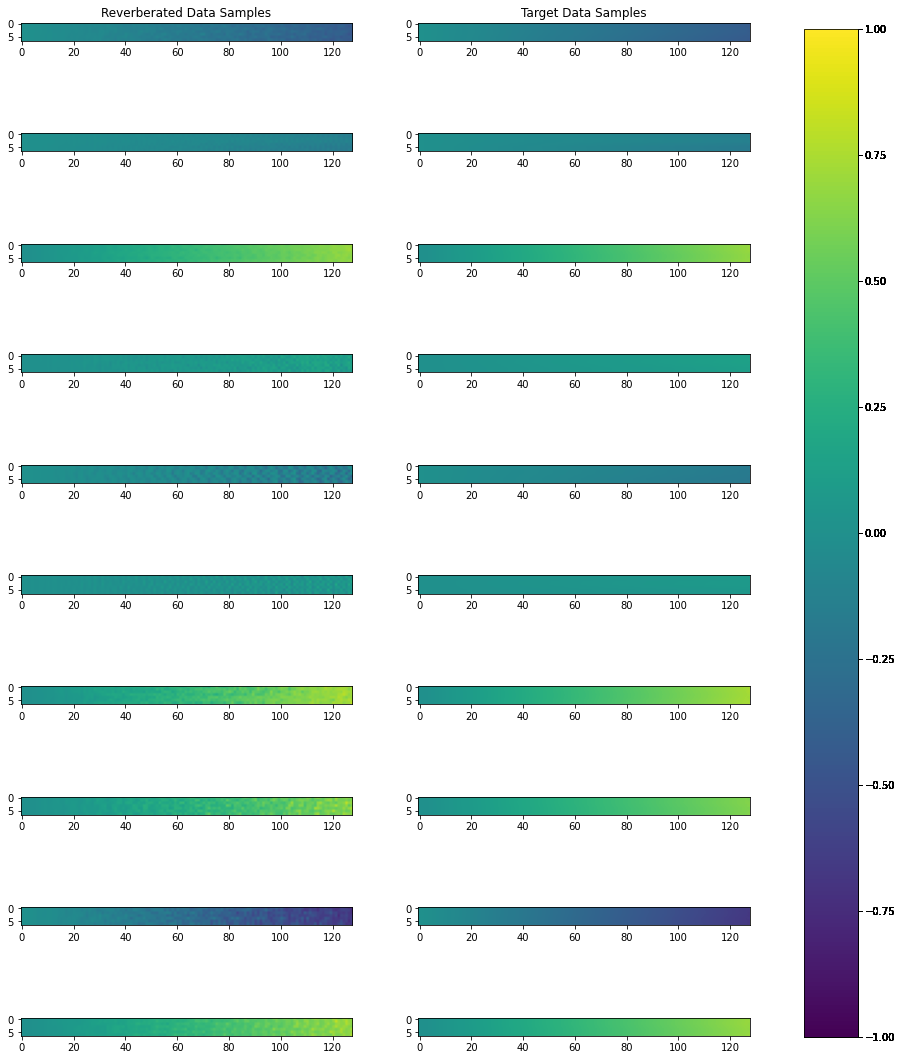

In [10]:
fig, axes = plt.subplots(10,2, figsize=(15,20))

l = []
for i in range(10):
    l.append(train_rev[i].squeeze())
    l.append(train_target[i].squeeze())

for j, (ax, im) in enumerate(zip(axes.ravel(), l)):
    m=ax.imshow(im)
    m.set_clim(vmin=-1, vmax=1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(m, cax=cbar_ax)
    # ax.axis('off')
    if j == 0:
        ax.set_title('Reverberated Data Samples')
    if j == 1:
        ax.set_title('Target Data Samples')
plt.show()

### Train Model

In [11]:
from logging import root
def train(G, D, train_dataloader, optimizer_G, optimizer_D,
          epochs, device, gen_loss_type, content_loss_lambda=0.9):
    G.train()  # set to training mode
    D.train()
    # TODO
    D_losses, G_losses = [], []
    D_losses_vs_epochs, G_losses_vs_epochs = [], []
    criterion = nn.BCELoss()
    for i in tqdm(range(1, epochs + 1), "Epoch"):
        for batch_idx, (inp_noisy, inp_target) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            inp_noisy = inp_noisy.to(device).float()
            inp_target = inp_target.to(device).float()
            G.zero_grad()
            if gen_loss_type == 'modified':
                y = torch.ones(inp_noisy.size(0), 1).to(device)
                G_out = G(inp_noisy)
                D_out = D(G_out)
                G_adv_loss = criterion(D_out, y)
                G_adv_loss.backward()

            elif gen_loss_type == 'standard':
                y = torch.zeros(inp_noisy.size(0), 1).to(device)  # zeros instead of ones
                G_out = G(inp_noisy)
                D_out = D(G_out)
                G_adv_loss = criterion(D_out, y)
                neg_G_loss = -G_adv_loss
                (neg_G_loss).backward()  # Minimizing the negative loss is as maximizing the loss
            else:
                raise ValueError('loss_type should be either \'standard\' or \'modified\' ')

            G_content_loss = torch.mean((G_out - inp_target).abs())
            G_loss = content_loss_lambda * G_content_loss + (1-content_loss_lambda) * G_adv_loss

            # gradient backprop & optimize ONLY G's parameters
            optimizer_G.step()
            G_losses.append(G_loss.item())

            # We can train the discriminator multiple times per each generator iteration, but we chose to do it once.
            for k in range(1):

                D.zero_grad()
                # train discriminator on target (real) samples
                y_real = torch.ones(inp_target.size(0), 1).to(device)

                D_out = D(inp_target)
                D_real_loss = criterion(D_out, y_real)

                # train discriminator on fake samples
                x_fake = G(inp_noisy)
                y_fake = torch.zeros(inp_noisy.size(0), 1).to(device)

                D_out = D(x_fake)
                D_fake_loss = criterion(D_out, y_fake)

                # Backprop
                D_loss = D_real_loss + D_fake_loss
                D_loss.backward()
                optimizer_D.step()

            D_losses.append(D_loss.item())

        print('Epoch[%d/%d]: Loss Disc: %.3f, Loss Gen: %.3f'
              % ((i), epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        G_losses_vs_epochs.append(torch.mean(torch.FloatTensor(G_losses)))
        D_losses_vs_epochs.append(torch.mean(torch.FloatTensor(D_losses)))

    return G_losses_vs_epochs, D_losses_vs_epochs


def sample(input, device):
    G.eval()  # set to inference mode
    input = input.to(device).float()
    with torch.no_grad():
        generated = G(input).detach().cpu()
    return generated

test_data = CustomImageDataset(root_dir, is_test=True, normalize=False, split_parts=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True,  num_workers=workers)

G = Generator(device).to(device)
D = Discriminator(device).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)

G_losses, D_losses = train(G, D, train_dataloader, optimizer_G, optimizer_D, epochs=num_epochs,
                               device=device, gen_loss_type='modified', content_loss_lambda=0.9)

Epoch:   5%|▌         | 1/20 [04:27<1:24:41, 267.44s/it]

Epoch[1/20]: Loss Disc: 1.021, Loss Gen: 0.240



Epoch:  10%|█         | 2/20 [08:59<1:21:00, 270.02s/it]

Epoch[2/20]: Loss Disc: 1.038, Loss Gen: 0.210



Epoch:  15%|█▌        | 3/20 [13:32<1:16:51, 271.28s/it]

Epoch[3/20]: Loss Disc: 1.050, Loss Gen: 0.202



Epoch:  20%|██        | 4/20 [18:06<1:12:41, 272.62s/it]

Epoch[4/20]: Loss Disc: 1.024, Loss Gen: 0.205



Epoch:  25%|██▌       | 5/20 [22:47<1:08:53, 275.55s/it]

Epoch[5/20]: Loss Disc: 1.001, Loss Gen: 0.210



Epoch:  30%|███       | 6/20 [27:19<1:03:59, 274.28s/it]

Epoch[6/20]: Loss Disc: 0.974, Loss Gen: 0.218



Epoch:  35%|███▌      | 7/20 [31:51<59:14, 273.46s/it]  

Epoch[7/20]: Loss Disc: 0.957, Loss Gen: 0.223



Epoch:  40%|████      | 8/20 [36:18<54:17, 271.48s/it]

Epoch[8/20]: Loss Disc: 0.928, Loss Gen: 0.231



Epoch:  45%|████▌     | 9/20 [40:38<49:06, 267.89s/it]

Epoch[9/20]: Loss Disc: 0.897, Loss Gen: 0.241



Epoch:  50%|█████     | 10/20 [45:01<44:25, 266.50s/it]

Epoch[10/20]: Loss Disc: 0.879, Loss Gen: 0.248



Epoch:  55%|█████▌    | 11/20 [49:33<40:12, 268.10s/it]

Epoch[11/20]: Loss Disc: 0.853, Loss Gen: 0.255



Epoch:  60%|██████    | 12/20 [54:03<35:50, 268.83s/it]

Epoch[12/20]: Loss Disc: 0.843, Loss Gen: 0.260



Epoch:  65%|██████▌   | 13/20 [58:29<31:14, 267.82s/it]

Epoch[13/20]: Loss Disc: 0.829, Loss Gen: 0.264



Epoch:  70%|███████   | 14/20 [1:03:00<26:53, 268.89s/it]

Epoch[14/20]: Loss Disc: 0.815, Loss Gen: 0.269



Epoch:  75%|███████▌  | 15/20 [1:07:29<22:24, 268.90s/it]

Epoch[15/20]: Loss Disc: 0.814, Loss Gen: 0.269



Epoch:  80%|████████  | 16/20 [1:11:56<17:53, 268.31s/it]

Epoch[16/20]: Loss Disc: 0.811, Loss Gen: 0.270



Epoch:  85%|████████▌ | 17/20 [1:16:23<13:23, 267.81s/it]

Epoch[17/20]: Loss Disc: 0.800, Loss Gen: 0.274



Epoch:  90%|█████████ | 18/20 [1:20:50<08:55, 267.50s/it]

Epoch[18/20]: Loss Disc: 0.794, Loss Gen: 0.276



Epoch:  95%|█████████▌| 19/20 [1:25:16<04:27, 267.04s/it]

Epoch[19/20]: Loss Disc: 0.789, Loss Gen: 0.278



Epoch: 100%|██████████| 20/20 [1:29:59<00:00, 270.00s/it]

Epoch[20/20]: Loss Disc: 0.789, Loss Gen: 0.278


### Save Generator Model

In [12]:
model_save_folder = project_dir + 'Denoising_DCGAN/'
G.save_gen(epoch=40, save_dir=model_save_folder)

FileNotFoundError: [Errno 2] No such file or directory: '../Denoising_DCGAN/Gen_Epoch_40.pt'

### Plot Learning Curve

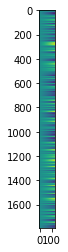

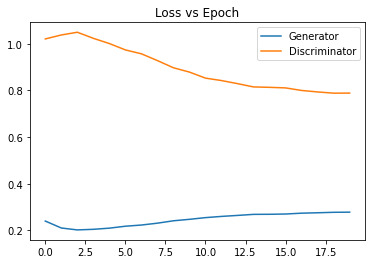

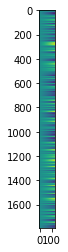

In [13]:

# Learning curve
plt.figure()
plt.plot(G_losses)
plt.plot(D_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss vs Epoch')

# Show inputs and their sampled outputs:
inp_noisy = next(iter(train_dataloader))[0]
show_data(np.squeeze(inp_noisy))


## Test

### Initialize dataset and dataloader

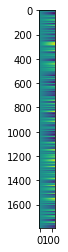

In [14]:
generated = sample(inp_noisy, device)
show_data(torch.squeeze(generated).cpu().detach().numpy())

test_data = CustomImageDataset(root_dir, is_test=True,split_parts=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

### Plot Test Images

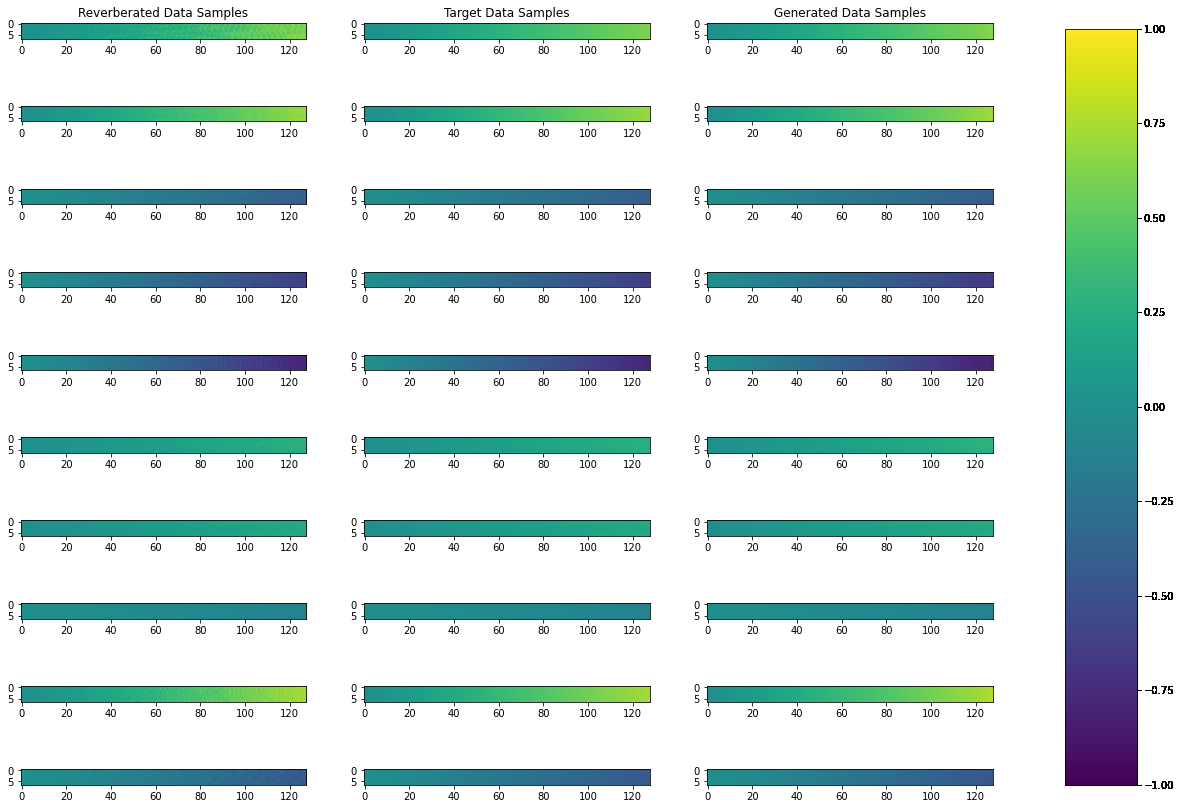

In [15]:
test_rev, test_target = next(iter(test_loader))
test_generated = sample(test_rev,device)

fig, axes = plt.subplots(10,3, figsize=(20,15))
l = []
for i in range(10):
    l.append(test_rev[i].cpu().squeeze())
    l.append(test_target[i].squeeze())
    l.append(test_generated[i].squeeze())

for j, (ax, im) in enumerate(zip(axes.ravel(), l)):
    m=ax.imshow(im)
    m.set_clim(vmin=-1, vmax=1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(m, cax=cbar_ax)
    # ax.axis('off')
    if j == 0:
        ax.set_title('Reverberated Data Samples')
    if j == 1:
        ax.set_title('Target Data Samples')
    if j == 2:
        ax.set_title('Generated Data Samples')
plt.show()

### Apply generator on test data, and show the output

FileNotFoundError: [Errno 2] No such file or directory: '../Denoising_DCGAN/Cleaned_Test_Data_beta=0.160_src=[3,3,1.2]/data_phase_epoch40.npy'

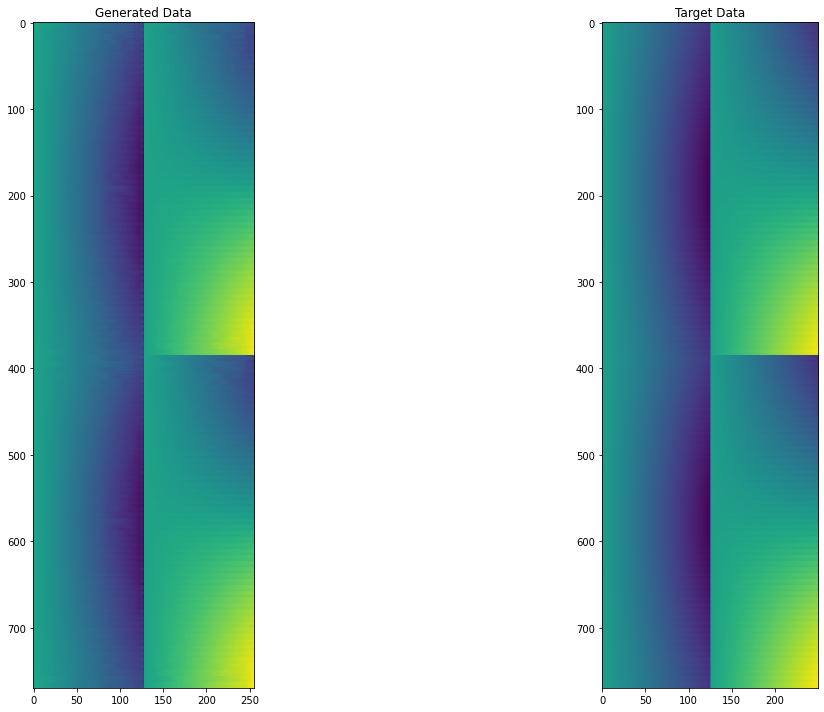

In [16]:
data_loadpath = root_dir + 'Test - room=[6,6,2.4], src=[3,3,1.2]/beta = 0.160/data_phase.npy'
data = np.load(data_loadpath)
data_savepath = model_save_folder +  'Cleaned_Test_Data_beta=0.160_src=[3,3,1.2]/'

data = data/np.pi

data_left = data[:,:,:125]
data_right = data[:,:,125:]

data_left = np.pad(data_left, ((0, 0),(0,0), (3, 0)), 'constant', constant_values=0)
data_right = np.pad(data_right, ((0, 0),(0,0), (3, 0)), 'constant', constant_values=0)

data_left_torch = torch.tensor(data_left).reshape([data_left.shape[0], 1, data_left.shape[1],data_left.shape[2]]).to(device)
data_right_torch = torch.tensor(data_right).reshape([data_left.shape[0], 1, data_left.shape[1],data_left.shape[2]]).to(device)

data_generated_left = np.zeros([data.shape[0],7,128])
data_generated_right = np.zeros([data.shape[0],7,128])
# Due to lack in gpu memory - apply in batches:
for k in range(data.shape[0]//batch_size):
    data_generated_left[k*batch_size:(k+1)*batch_size] = np.squeeze(G(data_left_torch[k*batch_size:(k+1)*batch_size].float()).detach().cpu().numpy())
    data_generated_right[k*batch_size:(k+1)*batch_size] = np.squeeze(G(data_right_torch[k*batch_size:(k+1)*batch_size].float()).detach().cpu().numpy())


data_generated = np.concatenate([data_generated_left,data_generated_right], axis=2)

# plt.figure()
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(data_generated.reshape([-1,256])[:770])
ax[0].set_title('Generated Data')
# compare with target data:
target_data_path = root_dir +  'Test - room=[6,6,2.4], src=[3,3,1.2]/Target (gpuRIR)/data_phase.npy'
target_data = np.load(target_data_path)
target_data = target_data / np.pi  # Apply the same normalization we did to training data
ax[1].imshow(target_data.reshape([-1,250])[:770])
ax[1].set_title('Target Data')
plt.tight_layout()

np.save(data_savepath + 'data_phase_epoch40.npy',data_generated)

# Load a saved generator:
gen_path = model_save_folder + 'Gen_Epoch_0.pt'
G = Generator(device).to(device)
G.load_model(gen_path)